In [1]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.tensorboard import SummaryWriter

import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from models_v2 import *
from torchcfm.utils import *
from torchcfm.optimal_transport import OTPlanSampler

import scipy as sp

from tqdm import tqdm
import imageio
from utils_hf import *

from phaseportrait import PhasePortrait2D

savedir = "models/double_well1d"
os.makedirs(savedir, exist_ok=True)


Here we consider the potential 
$$
\phi(x) = \alpha\frac{x^4}{4}+\beta\frac{x^2}{2}
$$
with $\alpha >0$ and $\beta<0$

In [2]:
alpha = 0.15
beta = -3

phi = lambda x: (alpha*x**4/4+beta*x**2/2)*1
phi_p = lambda x: (alpha*x**3+beta*x)*1

def phase_port_double_well(x,y):
    return np.array([y, -phi_p(x)])

In [22]:
t = torch.linspace(-7,7, 100)

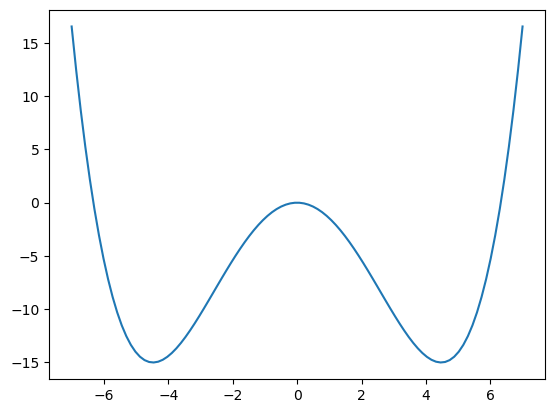

In [23]:
plt.plot(t, phi(t))

In [29]:
x0 = torch.normal(0,1,(500,))
means = torch.tensor([[-4.], [4.]])
stds = torch.tensor([[.25], [.25]])
weights = torch.tensor([.75, .25])
x1 = oned_gaussian_mixture(500, means, stds, weights)

Text(0, 0.5, 'V(x)')

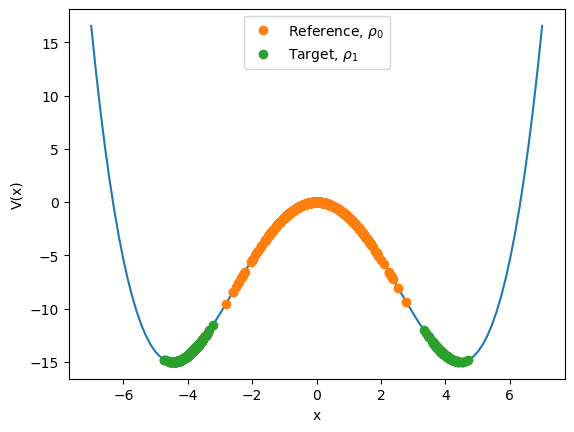

In [30]:
plt.plot(t, phi(t))
plt.plot(x0,phi(x0), 'o',label = r'Reference, $\rho_0$')
plt.plot(x1,phi(x1), 'o',label = r'Target, $\rho_1$')
plt.legend()
plt.xlabel('x')
plt.ylabel('V(x)')

/work2/Sebas/anaconda3/envs/Hamiltonian_Flows_Wass/lib/python3.10/site-packages/phaseportrait/streamlines/streamlines_base.py:137: RuntimeWarning: divide by zero encountered in divide
  deltat = np.min(self.get_delta_coordinates(*coords)/(10*np.max(np.abs(_speed))))


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Phase Portrait'}, xlabel='X', ylabel='$p$'>)

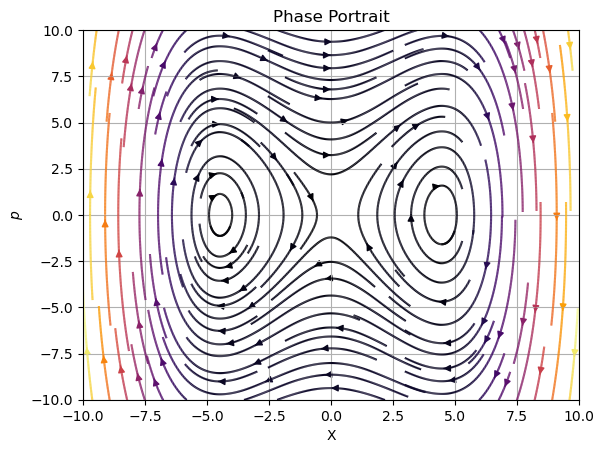

In [7]:
phase_portrait = PhasePortrait2D(phase_port_double_well, [-10,10], Density=3, color='inferno')
# phase_portrait.add_nullclines()
phase_portrait.ylabel = r'$p$'
phase_portrait.plot()

They dynamics for PWHF are given by the dynamical system
\begin{align}
x' &= y\\
y' &= -\alpha x^3-x(\beta+3\alpha z^2)\\
z' &=w \\
w' &= -3\alpha z^3-z(\beta+3\alpha x^2).
\end{align}
In terms of Gaussian parameters $(\mu,\sigma) = (x,z)$

In [3]:
def par_dynamics(t,p):
    x,y,z,w = p

    return np.array([y,-alpha*x**3-x*(beta+alpha*3*z**2), w, -3*alpha*z**3 - z*(beta+alpha*3*x**2)])

I am curions, given deterministic positions, do the dynamics remain deterministic? It makes sense that they do. 

In [4]:
def bc(ya,yb):
    return np.array([ya[0],ya[2]-.1,yb[0]+1,yb[2]-.01])

In [5]:
# Mesh
collocation_pts = np.linspace(0,1,5)

# Initial guess
ya = np.ones((4, collocation_pts.size))*2


In [6]:
sol = sp.integrate.solve_bvp(par_dynamics, bc, collocation_pts, ya,tol = 1,verbose=2)

sol_f = lambda t: sol.sol(t)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          3.53e-03       2.24e-19           5              0       
Solved in 1 iterations, number of nodes 5. 
Maximum relative residual: 3.53e-03 
Maximum boundary residual: 2.24e-19


In [7]:
t = np.linspace(0,1,100)
mu_t,mu_t_p,sig_t,sig_t_p = sol_f(t)

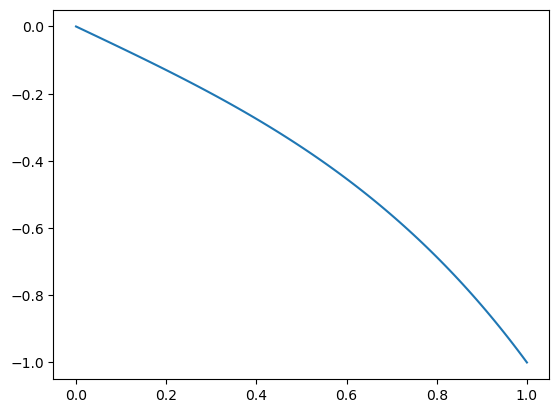

In [8]:
plt.plot(t,mu_t)

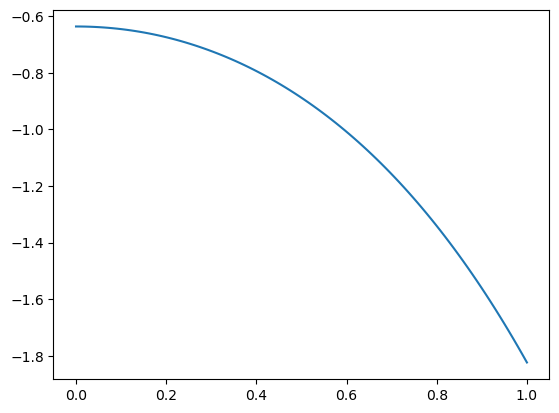

In [9]:
plt.plot(t,mu_t_p)

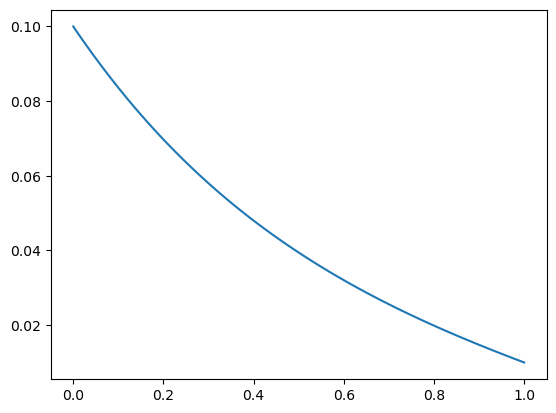

In [10]:
plt.plot(t,sig_t)

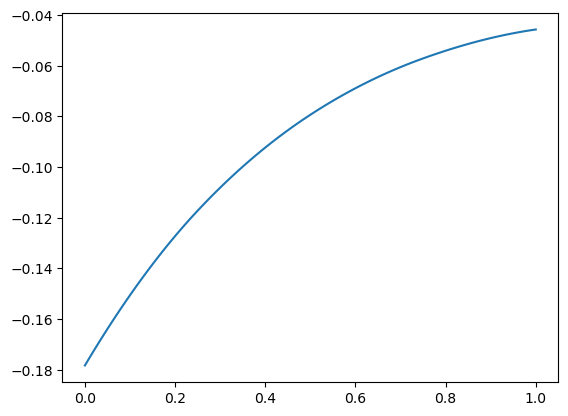

In [11]:
plt.plot(t,sig_t_p)

Plot in the phase portrait. We are going to sample from $(N(\mu_t,\sigma_t),N(\mu'_t,\sigma_t'))$

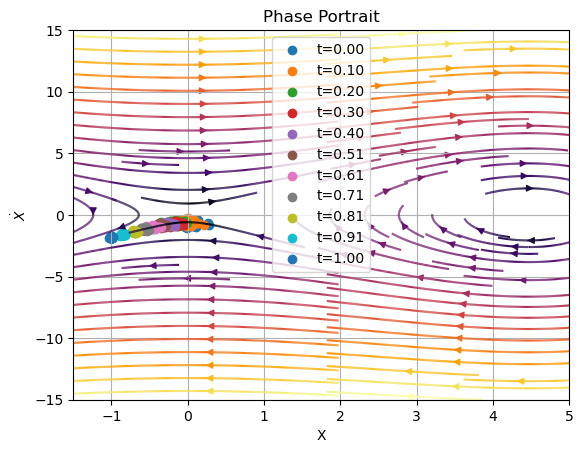

In [17]:
phase_portrait = PhasePortrait2D(phase_port_double_well, [[-1.5,5],[-15,15]], Density=3, color='inferno')
for tt in range(0,len(t),10):
    x = np.random.normal(mu_t[tt],np.abs(sig_t[tt]),50)
    p = np.random.normal(mu_t_p[tt],np.abs(sig_t_p[tt]),50)
    plt.scatter(x,p,label=f"t={t[tt]:.2f}")

tt = -1
x = np.random.normal(mu_t[tt],sig_t[tt],50)
p = np.random.normal(mu_t_p[tt],np.abs(sig_t_p[tt]),50)
plt.scatter(x,p,label=f"t={t[tt]:.2f}")


phase_portrait.plot()
plt.legend()
# plt.show()

This experiment is quite succesfull, we now solve the problem using CFM for large scale distributions. We choose $\mu \sim N(0,1)$ to the Gaussian mixture $N(-2,1)$ and $N(2,1)$ with weights $1/2$

In [19]:
# Gaussian mixture sampler

def oned_gaussian_mixture(n_samples, means, stds, weights):
    samples_per_component = torch.multinomial(weights, n_samples, replacement=True)
    # samples_per_component = torch.random.multinomial(n_samples, weights)
    samples = torch.zeros((n_samples,1))
    for i in range(n_samples):
        samples[i] += torch.normal(means[samples_per_component[i]], stds[samples_per_component[i]])
    return samples

In [12]:
# Problem set up

dim = 1
batch_size = 100
n_iters = 5_000
architecture = 'MLP'
ot_sampler = OTPlanSampler(method="exact")

means = torch.tensor([[-4.], [4.]])
stds = torch.tensor([[.25], [.25]])
weights = torch.tensor([.75, .25])

In [13]:
sigma = 0.1

collocation_pts = np.linspace(0,1,10)
# Initial guess
ya = np.ones((4, collocation_pts.size))*.5

# model_ent_match = ResNet(dim= dim,hidden=2,time_varying= True)
if architecture == 'ResNet':
    model_harmonic = ResNet(dim= dim,hidden=2,w=128,time_varying= True)
else: 
    model_harmonic = MLP(dim= dim,w=64,time_varying= True)
optimizer = torch.optim.AdamW(model_harmonic.parameters(), lr=1e-3)#,momentum=0.9)

  0%|          | 0/50 [00:00<?, ?it/s]/work2/Sebas/anaconda3/envs/Hamiltonian_Flows_Wass/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.7247171814159D+13   r2 =  0.6748205451295D+04
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 = -0.7247171814159D+13   r2 = -0.6748205451295D+04


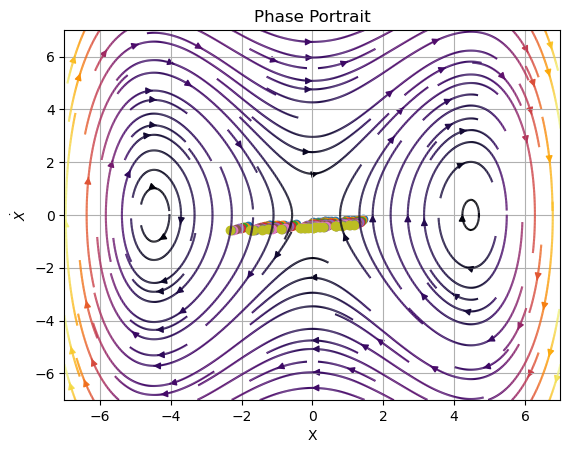

100%|██████████| 50/50 [00:03<00:00, 15.69it/s]


In [114]:
pbar = tqdm(total=n_iters, desc="Training")
writer = SummaryWriter()

num_samples = 100
time_steps = 150
for j in tqdm(range(n_iters)):
    optimizer.zero_grad()

    t = torch.rand((batch_size,1))#.requires_grad_(True)

    x0 = torch.normal(0,1,(batch_size,1))
    x1 = oned_gaussian_mixture(batch_size, means, stds, weights)

    x0, x1 = ot_sampler.sample_plan(x0, x1)
    
    x0 = x0#.unsqueeze(-1)
    x1 = x1#.unsqueeze(-1)

    epsilon = torch.randn_like(x0)


    xt = torch.zeros_like(x0)#.requires_grad_(True)
    ut = torch.zeros_like(x0)

    # solve bvp per batch element
    for k in range(batch_size):

        bc = lambda ya,yb: np.array([ya[0]-x0[k][0].numpy(),ya[2]-sigma,yb[0]-x1[k][0].numpy(),yb[2]-sigma])
        sol = sp.integrate.solve_bvp(par_dynamics, bc, collocation_pts, ya,tol = 1,verbose=0)
        sol_f = lambda t: sol.sol(t)
        mu_t,mu_t_prime,sig_t,sig_t_prime = torch.from_numpy(sol_f(t[k].numpy())).float()
        xt[k] = mu_t + torch.abs(sig_t)*epsilon[k]
        ut[k] = torch.abs(sig_t_prime)*epsilon[k]+mu_t_prime#sig_t_prime*(xt[k]-mu_t)/(sig_t+1e-8) + mu_t_prime

    vt = model_harmonic(torch.cat([xt,t],dim = -1))
    # vt_xt = torch.autograd.grad(vt.sum(),xt,create_graph=True)[0]
    # vt_t = torch.autograd.grad(vt.sum(),t,create_graph=True)[0]

    grad_pot = phi_p(xt)
    # hamiltonian_loss = torch.abs(vt_t + vt_xt*vt-grad_pot).mean()
    # print(vt[0],ut[0])
    # loss = torch.mean(torch.norm(vt - ut)**2)
    loss = torch.nn.MSELoss()(vt,ut)#+0.1*hamiltonian_loss
    writer.add_scalar('Loss', loss.item(), k)

    # Update the progress bar
    pbar.set_description("Loss: %.3f" % loss.item())
    pbar.update()
    

    loss.backward()
    optimizer.step()

    if (j ) % 1000 == 0:
        node = NeuralODE(torch_wrapper(model_harmonic), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4        )
        
        with torch.no_grad():
            # print(loss.item())
            phase_portrait = PhasePortrait2D(phase_port_double_well, [[-7,7],[-7,7]], Density=1, color='inferno')
            traj = node.trajectory(
                torch.normal(0,1,(num_samples,1)),
                # sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, time_steps),
            )
            vt = torch.zeros_like(traj)
            t = torch.linspace(0, 1, time_steps)
            for k in range(len(traj)):
                vt[k,:] = model_harmonic(torch.cat([traj[k,:],t[k]*torch.ones_like(traj[k,:])],dim = -1))#.squeeze(-1)

            traj_np,vt_np =traj.detach().numpy(),vt.detach().numpy()
            

            for i in range(1,time_steps,20):
                x = traj_np[i,0:-1:5]
                p = vt_np[i,0:-1:5]
                plt.scatter(x,p,label=f"t={t[i]:.2f}")

            x = traj_np[-1,0:-1:5]
            p = vt_np[-1,0:-1:5]
            plt.scatter(x,p,label=f"t={t[i]:.2f}")

            phase_portrait.plot()

            plt.show()
        



In [38]:
# model_harmonic.state_dict(torch.load(os.path.join(savedir,"model_double_well1d_g_GM.pth")))

In [29]:
torch.save(model_harmonic.state_dict(), f"{savedir}/model_double_well1d_g_GM_unbalanced_reg_PDE_2.pth")

In [40]:
model_harmonic.load_state_dict(torch.load(f"{savedir}/model_double_well1d_g_GM_unbalanced_reg_PDE_3.pth"))

<All keys matched successfully>

In [47]:
model_harmonic.eval()
node = NeuralODE(torch_wrapper(model_harmonic), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
num_samples = 500
time_steps = 1000
with torch.no_grad():
    # print(loss.item())
    traj = node.trajectory(
        torch.normal(0,1,(num_samples,1)),
        # sample_8gaussians(1024),
        t_span=torch.linspace(0, 1, time_steps),
    )

In [48]:
vt = torch.zeros_like(traj)
t = torch.linspace(0, 1, time_steps)
for k in range(len(traj)):
    vt[k,:] = model_harmonic(torch.cat([traj[k,:],t[k]*torch.ones_like(traj[k,:])],dim = -1))#.squeeze(-1)

traj_np,vt_np =traj.detach().numpy(),vt.detach().numpy()

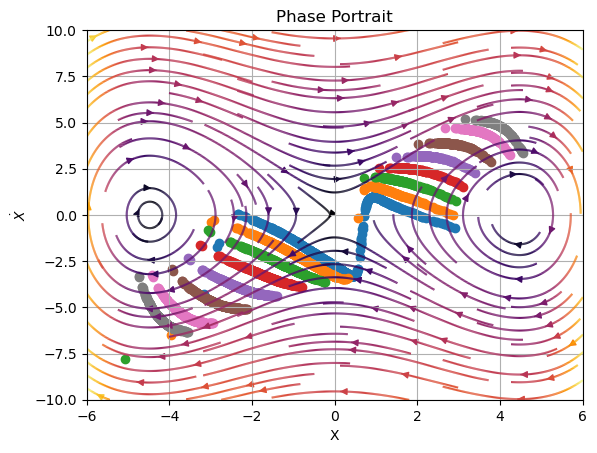

In [49]:
phase_portrait = PhasePortrait2D(phase_port_double_well, [[-6,6],[-10,10]], Density=1, color='inferno')

for i in range(1,time_steps,150):
    x = traj_np[i,0:-1]
    p = vt_np[i,0:-1]
    plt.scatter(x,p,label=f"t={t[i]:.2f}")

x = traj_np[-1,0:-1]
p = vt_np[-1,0:-1]
plt.scatter(x,p,label=f"t={t[i]:.2f}")

phase_portrait.plot()
phase_portrait.ylabel = r'$p$'

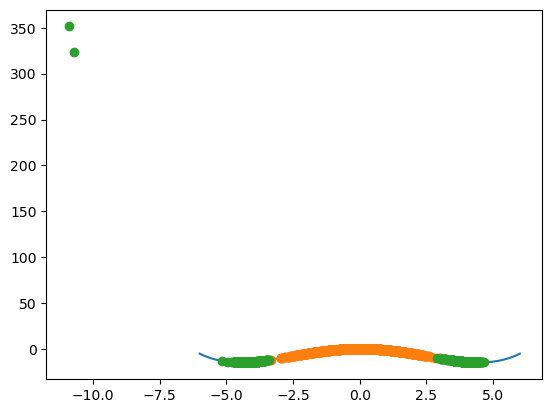

In [44]:
t_eval = np.linspace(-6,6,100)
plt.plot(t_eval, phi(t_eval))
plt.plot(traj_np[0,:],phi(traj_np[0,:]), 'o',label = r'Reference, $\rho_0$')
plt.plot(traj_np[-1,:],phi(traj_np[-1,:]), 'o',label = r'Target, $\rho_1$')

(array([0.00051476, 0.        , 0.        , 0.00308853, 0.48026654,
        0.        , 0.        , 0.        , 0.00102951, 0.15854458]),
 array([-10.90206623,  -9.347929  ,  -7.79379225,  -6.23965502,
         -4.68551779,  -3.1313808 ,  -1.57724369,  -0.02310662,
          1.53103042,   3.08516765,   4.63930464]),
 <BarContainer object of 10 artists>)

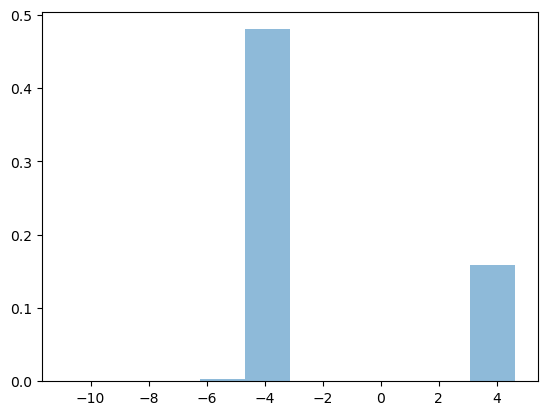

In [45]:
plt.hist(traj_np[-1,:],density=True,alpha=0.5)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Phase Portrait'}, xlabel='X', ylabel='$\\dot{X}$'>)

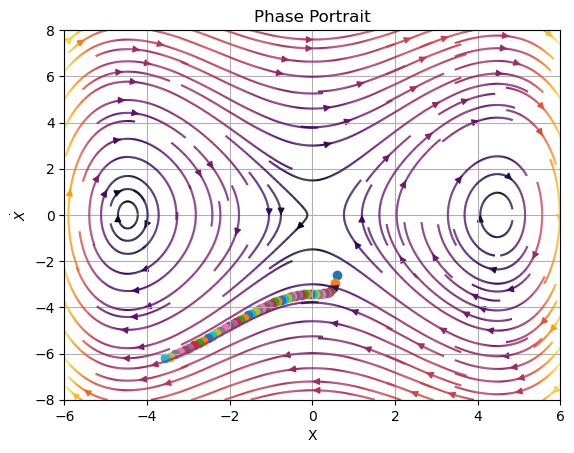

In [46]:
phase_portrait = PhasePortrait2D(phase_port_double_well, [[-6,6],[-8,8]], Density=3, color='inferno')
k = np.random.randint(0,num_samples)
for i in range(1,time_steps,20):
    x = traj_np[i,k]
    p = vt_np[i,k]
    plt.scatter(x,p,label=f"t={t[i]:.2f}")

x = traj_np[-1,k]
p = vt_np[-1,k]
# plt.scatter(x,p,label=f"t={t[i]:.2f}")

phase_portrait.plot()

In [15]:
np.mean(traj_np[-1,:])
np.std(traj_np[-1,:])

3.6147509

In [74]:
# Problem set up

dim = 1
batch_size = 500
n_iters = 5_000
architecture = 'MLP'
ot_sampler = OTPlanSampler(method="exact")

means = torch.tensor([[-4.], [4.]])
stds = torch.tensor([[.25], [.25]])
weights = torch.tensor([.75, .25])
sigma = 0.05

collocation_pts = np.linspace(0,1,10)
# Initial guess
ya = np.ones((4, collocation_pts.size))*1.5

In [39]:


# model_ent_match = ResNet(dim= dim,hidden=2,time_varying= True)
if architecture == 'ResNet':
    model_harmonic = ResNet(dim= dim,hidden=2,w=128,time_varying= True)
else: 
    model_harmonic = MLP(dim= dim,w=64,time_varying= True)
optimizer = torch.optim.AdamW(model_harmonic.parameters(), lr=1e-3)#,momentum=0.9)

Loss: 0.107:   0%|          | 1/5000 [00:01<1:28:49,  1.07s/it]

 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.7247171814159D+13   r2 =  0.6748205451295D+04
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 = -0.7247171814159D+13   r2 = -0.6748205451295D+04


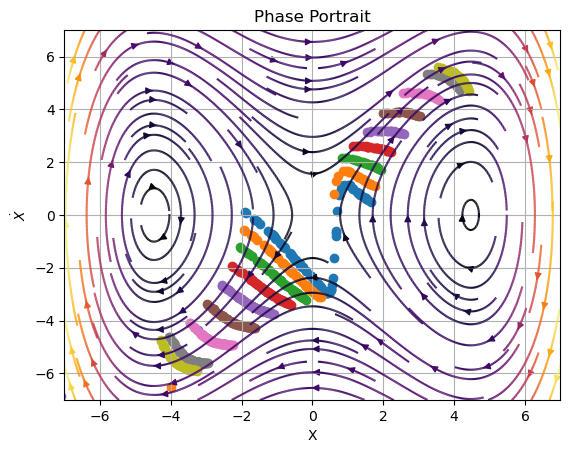

Loss: 0.205:  20%|██        | 1001/5000 [17:40<1:10:36,  1.06s/it]

 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.7247171814159D+13   r2 =  0.6748205451295D+04
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 = -0.7247171814159D+13   r2 = -0.6748205451295D+04


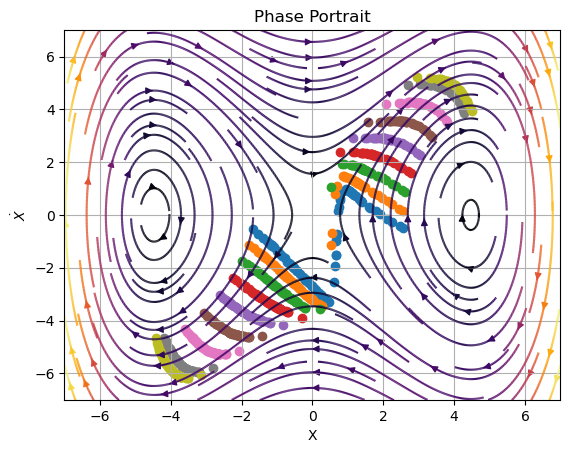

Loss: 0.173:  40%|████      | 2001/5000 [35:26<52:54,  1.06s/it]  

 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.7247171814159D+13   r2 =  0.6748205451295D+04
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 = -0.7247171814159D+13   r2 = -0.6748205451295D+04


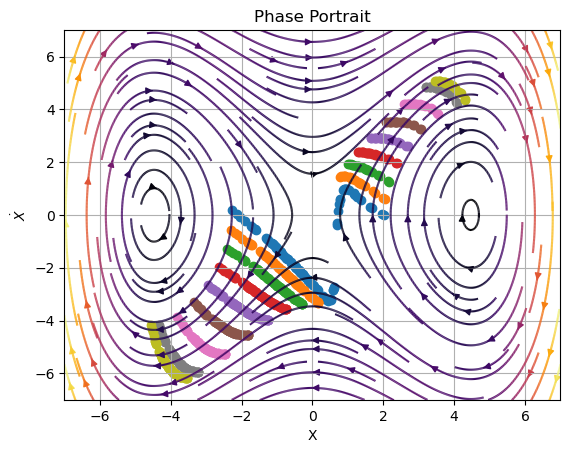

Loss: 0.069:  60%|██████    | 3001/5000 [53:09<35:28,  1.06s/it]  

 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.7247171814159D+13   r2 =  0.6748205451295D+04
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 = -0.7247171814159D+13   r2 = -0.6748205451295D+04


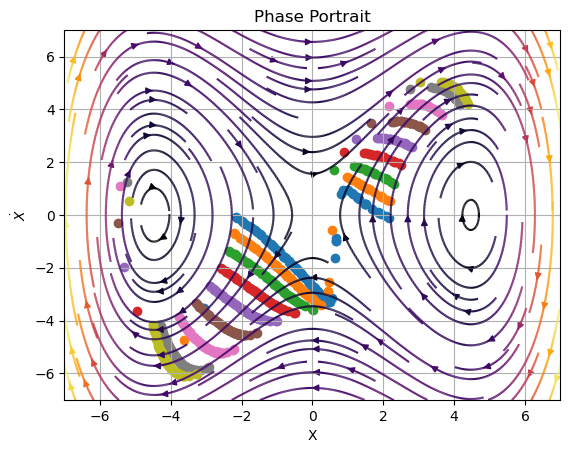

Loss: 0.082:  80%|████████  | 4001/5000 [1:10:52<17:43,  1.06s/it]

 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.7247171814159D+13   r2 =  0.6748205451295D+04
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 = -0.7247171814159D+13   r2 = -0.6748205451295D+04


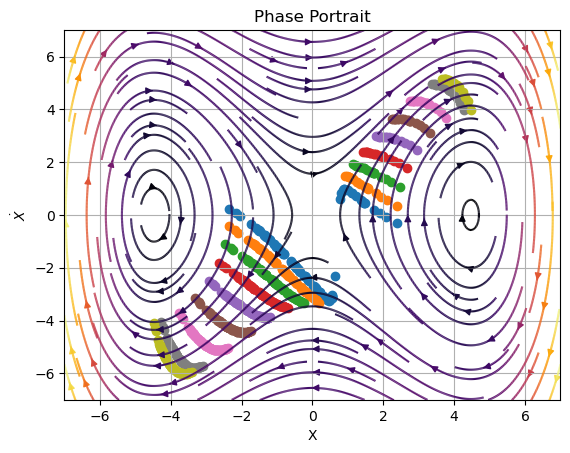

100%|██████████| 5000/5000 [1:28:29<00:00,  1.06s/it]0,  1.05s/it]


In [75]:
pbar = tqdm(total=n_iters, desc="Training")
writer = SummaryWriter()
model_harmonic.train()
num_samples = 100
time_steps = 150
for j in tqdm(range(n_iters)):
    optimizer.zero_grad()

    t = torch.rand((batch_size,1))

    x0 = torch.normal(0,1,(batch_size,1))
    x1 = oned_gaussian_mixture(batch_size, means, stds, weights)

    x0, x1 = ot_sampler.sample_plan(x0, x1)
    
    x0 = x0#.unsqueeze(-1)
    x1 = x1#.unsqueeze(-1)

    epsilon = torch.randn_like(x0)


    xt = torch.zeros_like(x0)
    ut = torch.zeros_like(x0)

    # solve bvp per batch element
    for k in range(batch_size):

        bc = lambda ya,yb: np.array([ya[0]-x0[k][0].numpy(),ya[2]-sigma,yb[0]-x1[k][0].numpy(),yb[2]-sigma])
        sol = sp.integrate.solve_bvp(par_dynamics, bc, collocation_pts, ya,tol = 1,verbose=0)
        sol_f = lambda t: sol.sol(t)
        mu_t,mu_t_prime,sig_t,sig_t_prime = torch.from_numpy(sol_f(t[k].numpy())).float()
        
        xt[k] = mu_t + torch.abs(sig_t)*epsilon[k]
        ut[k] = torch.abs(sig_t_prime)*epsilon[k]+mu_t_prime#sig_t_prime*(xt[k]-mu_t)/(sig_t+1e-8) + mu_t_prime
    xt = xt.clone().requires_grad_(True)
    t = t.clone().requires_grad_(True)
    vt = model_harmonic(torch.cat([xt,t],dim = -1))
    vt_squared = vt * vt
    vt_squared_grad = torch.autograd.grad(vt_squared.sum(), xt, create_graph=True)[0]
    vt_t = torch.autograd.grad(vt.sum(),t,create_graph=True)[0]

    grad_pot = phi_p(xt)
    hamiltonian_loss = torch.abs(vt_t + vt_squared_grad/2+grad_pot).mean()
    # print(hamiltonian_loss)
    # print(vt[0],ut[0])
    # loss = torch.mean(torch.norm(vt - ut)**2)
    loss = torch.nn.MSELoss()(vt,ut)+0.15*hamiltonian_loss
    writer.add_scalar('Loss', loss.item(), k)

    # Update the progress bar
    pbar.set_description("Loss: %.3f" % loss.item())
    pbar.update()
    
    # xt.grad.zero_()
    # t.grad.zero_()
    loss.backward()
    optimizer.step()

    if (j ) % 1000 == 0:
        torch.save(model_harmonic.state_dict(), f"{savedir}/model_double_well1d_g_GM_unbalanced_reg_PDE_3.pth")
        node = NeuralODE(torch_wrapper(model_harmonic), solver="ieuler", sensitivity="adjoint", atol=1e-4, rtol=1e-4        )
        
        with torch.no_grad():
            # print(loss.item())
            phase_portrait = PhasePortrait2D(phase_port_double_well, [[-7,7],[-7,7]], Density=1, color='inferno')
            traj = node.trajectory(
                torch.normal(0,1,(num_samples,1)),
                # sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, time_steps),
            )
            vt = torch.zeros_like(traj)
            t = torch.linspace(0, 1, time_steps)
            for k in range(len(traj)):
                vt[k,:] = model_harmonic(torch.cat([traj[k,:],t[k]*torch.ones_like(traj[k,:])],dim = -1))#.squeeze(-1)

            traj_np,vt_np =traj.detach().numpy(),vt.detach().numpy()
            

            for i in range(1,time_steps,20):
                x = traj_np[i,0:-1]
                p = vt_np[i,0:-1]
                plt.scatter(x,p,label=f"t={t[i]:.2f}")

            x = traj_np[-1,0:-1]
            p = vt_np[-1,0:-1]
            plt.scatter(x,p,label=f"t={t[i]:.2f}")

            phase_portrait.plot()

            plt.show()
        



Evaluate the hamiltonian 
$$
\frac{1}{2}||V_t(x_t)||^2 + \phi(X_t)
$$

In [82]:
N = 1000
t = torch.linspace(0, 1, N)
num_samples =10_000
x0 = torch.normal(0,1,(num_samples,1))
hamiltonian = np.zeros(N)


In [83]:
model_harmonic.eval()
node = NeuralODE(torch_wrapper(model_harmonic), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
with torch.no_grad():
    traj = node.trajectory(x0,t_span=torch.linspace(0, 1, N))

In [84]:
for i in range(N):

    tt = t[i]*torch.ones((num_samples,1))

    pot = phi(traj[i]).mean()

    kinetic = 0.5*(torch.linalg.vector_norm(model_harmonic(torch.cat([traj[i],tt],dim = -1)),dim = -1)**2).mean() 
    
    hamiltonian[i] = pot +  kinetic



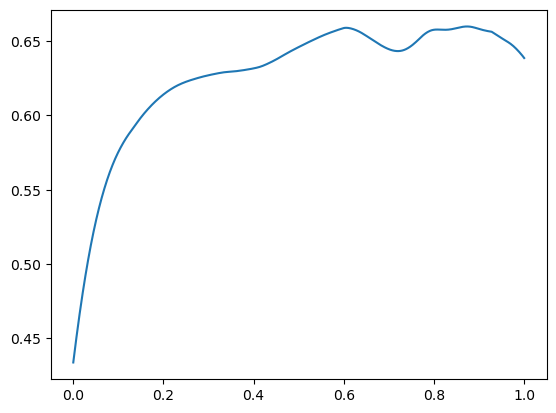

In [85]:
plt.plot(t,hamiltonian)

In [86]:
relative_error = (hamiltonian - hamiltonian[0])/hamiltonian[0]

Text(0, 0.5, 'Relative Hamiltonian')

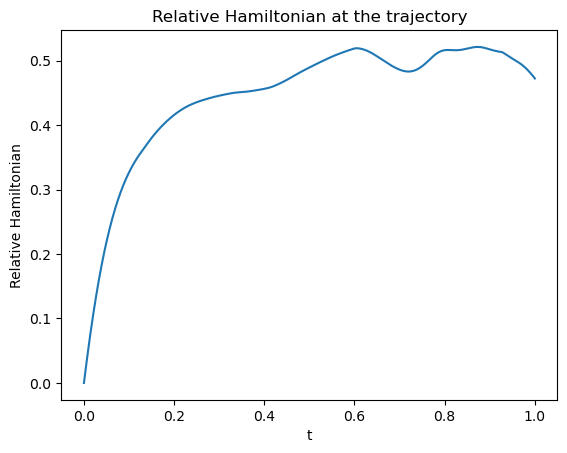

In [87]:
plt.plot(t,relative_error)
plt.title("Relative Hamiltonian at the trajectory")
plt.xlabel("t")
plt.ylabel("Relative Hamiltonian")
# plt.savefig(os.path.join(savedir,f"hamiltonian_relative_error_small_exp.png"))

In [116]:
def learned_vf(x,y):
    print(x.astype(np.float32))
    print(torch.from_numpy(x))
    print(torch.zeros(1))
    print(model_harmonic(torch.cat([torch.from_numpy(x),torch.zeros(1)],dim = -1)))
    print([y, model_harmonic(torch.cat([torch.from_numpy(x),torch.zeros(1)],dim = -1))])
    return np.array([y, model_harmonic(torch.cat([torch.from_numpy(x),torch.zeros(1)],dim = -1))])

In [117]:
learned_vf(0,0)

AttributeError: 'int' object has no attribute 'astype'

TypeError: expected np.ndarray (got numpy.float64)

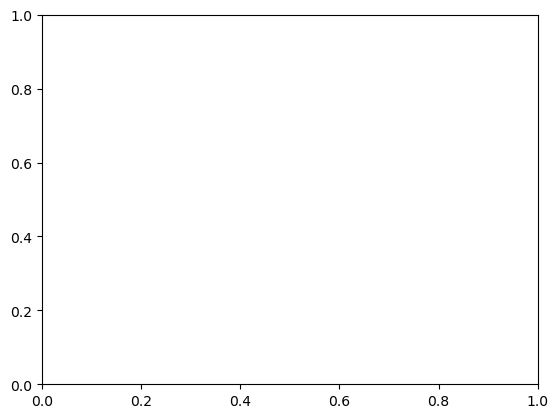

In [108]:
learned_phase = PhasePortrait2D(learned_vf, [[-6,6],[-8,8]], Density=3, color='inferno')
learned_phase.plot()

In [ ]:
tensor.from